## Matching Exercise

### Nick Carroll & Yuanjing Zhu

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import altair as alt
%config InlineBackend.figure_format = 'retina'

In [2]:
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)

In [3]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


## Exercise 1

In [4]:
annual_earnings_with_college = cps.loc[cps['has_college']==1, 'annual_earnings']
annual_earnings_without_college = cps.loc[cps['has_college']==0, 'annual_earnings']

raw_diff = annual_earnings_with_college.mean() - annual_earnings_without_college.mean()
print(f'The raw difference of annual_earnings between those with and without a college degree {raw_diff:.2f}')

The raw difference of annual_earnings between those with and without a college degree 14158.50


In [5]:
_, pvalue = stats.ttest_ind(annual_earnings_with_college, annual_earnings_without_college, nan_policy='omit')
print(f'The p-value for the t-test is {pvalue:.2f}')

The p-value for the t-test is 0.00


The difference is statistically significant

## Exercise 2

In [7]:
cps['simplified_race'].value_counts()

0.0    7622
2.0    1512
1.0    1020
3.0     996
Name: simplified_race, dtype: int64

In [12]:
college_by_race = cps.groupby("simplified_race")["has_college"].mean()

print("Share of people in different racial groups who have college degrees:")
print(college_by_race)

Share of people in different racial groups who have college degrees:
simplified_race
0.0    0.438205
1.0    0.317647
2.0    0.198413
3.0    0.474900
Name: has_college, dtype: float64


In [8]:
cross_tab = pd.crosstab(cps['simplified_race'], cps['has_college'])
_, p, _, _ = stats.chi2_contingency(cross_tab)
print(f"P-value for chi-square test: {p:.2f}")

P-value for chi-square test: 0.00


Those differences are statistically significant

In [9]:
l_avg = []
l_std = []
for i in cps['county'].unique():
    l_avg.append(cps.loc[cps['county']==i, 'annual_earnings'].mean())
    l_std.append(cps.loc[cps['county']==i, 'annual_earnings'].std())

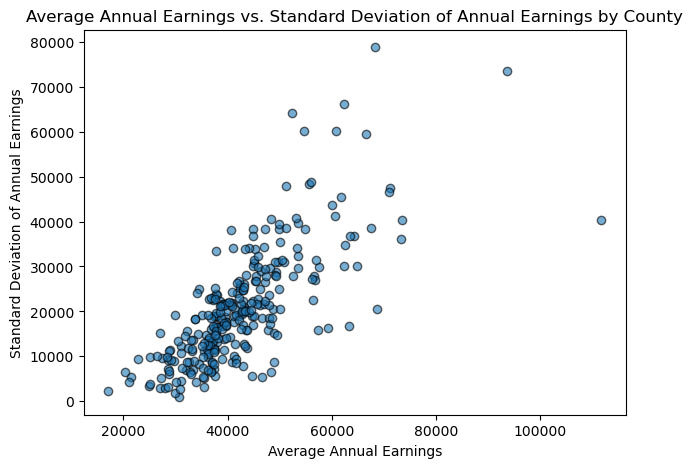

In [10]:
plt.figure(figsize=(7,5), dpi=100)
plt.scatter(l_avg, l_std, edgecolors='black', alpha=0.6)
plt.xlabel('Average Annual Earnings')
plt.ylabel('Standard Deviation of Annual Earnings')
plt.title('Average Annual Earnings vs. Standard Deviation of Annual Earnings by County')
plt.show()

Distribution looks different across counties

not balanced

### Exercise 3

In [13]:
alt.data_transformers.disable_max_rows()
base = (
    alt.Chart(cps).mark_point().encode(
        x = 'age',
        y = 'annual_earnings',
    )
)

loess = base.transform_loess(
    'age', 'annual_earnings').mark_line(color='red')

base + loess


e:\miniconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

Does the relationship look linear?

Does this speak to why it’s nice to not have to think about functional forms with matching as much?

### Exercise 4

In [14]:
print(f"Age range: {cps['age'].min()} to {cps['age'].max()}")

Age range: 16 to 85


In [15]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90]
pd.cut(cps['age'], bins=bins).value_counts().sort_index()

(0, 20]      214
(20, 30]    2047
(30, 40]    2737
(40, 50]    2582
(50, 60]    2315
(60, 70]    1082
(70, 80]     156
(80, 90]      17
Name: age, dtype: int64

Create a new variable that discretizes age:
- 0-20: 0
- 21-30: 1
- 31-40: 2
- 41-50: 3
- 51-60: 4
- 61-70: 5
- 71-90: 6

In [16]:
# create a new varibalbe that discretizes age into 7 bins
cps.loc[cps['age'] <= 20, 'age_group'] = 0
cps.loc[(cps['age'] > 20) & (cps['age'] <= 30), 'age_group'] = 1
cps.loc[(cps['age'] > 30) & (cps['age'] <= 40), 'age_group'] = 2
cps.loc[(cps['age'] > 40) & (cps['age'] <= 50), 'age_group'] = 3
cps.loc[(cps['age'] > 50) & (cps['age'] <= 60), 'age_group'] = 4
cps.loc[(cps['age'] > 60) & (cps['age'] <= 70), 'age_group'] = 5
cps.loc[cps['age'] > 70, 'age_group'] = 6
cps['age_group'] = cps['age_group'].astype(int)

### Exercise 5

In [17]:
# convert county and class94 to a numeric vector of intergers using pd.Categorical
cps['county'] = pd.Categorical(cps['county']).codes
cps['class94'] = pd.Categorical(cps['class94']).codes

### Exercise 6

In [19]:
# drop the original variables that we dont need 
cps_2 = cps.copy()   # create a copy of the dataframe
cps_2.drop(columns=['age', 'index'], inplace=True)
cps_2.dropna(inplace=True)
cps_2.reset_index(inplace=True, drop=True)
cps_2.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group
0,42900.0,1,0.0,0,10,3,4
1,31200.0,0,2.0,0,31,3,2
2,20020.0,0,0.0,1,8,3,5
3,22859.2,0,0.0,0,44,1,3
4,73860.8,0,0.0,1,24,3,2


### Exercise 7

In [20]:
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    cps_2,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(cps_2)

Completed iteration 0 of matching
	Number of matched groups formed in total:  377
	Unmatched treated units:  635 out of a total of  1150 treated units
	Unmatched control units:  3221 out of a total of  4365 control units
	Number of matches made this iteration:  1659
	Number of matches made so far:  1659
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1202376350.38702
Completed iteration 1 of matching
	Number of matched groups formed in total:  503
	Unmatched treated units:  21 out of a total of  1150 treated units
	Unmatched control units:  353 out of a total of  4365 control units
	Number of matches made this iteration:  3482
	Number of matches made so far:  5141
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1202496430.8826103
Completed iteration 2 of matching
	Number of matched groups formed in total:  503
	Unmatched treated units:  21 out of a total of  1150 treated units
	Unmatched control

### Exercise 8

In [21]:
model.pe_each_iter

[1202376350.38702,
 1202496430.8826103,
 1207802376.3253863,
 1207815700.455237,
 1208262317.0985746,
 1208371357.6182184,
 1213721373.4911957,
 1213734293.9564407]

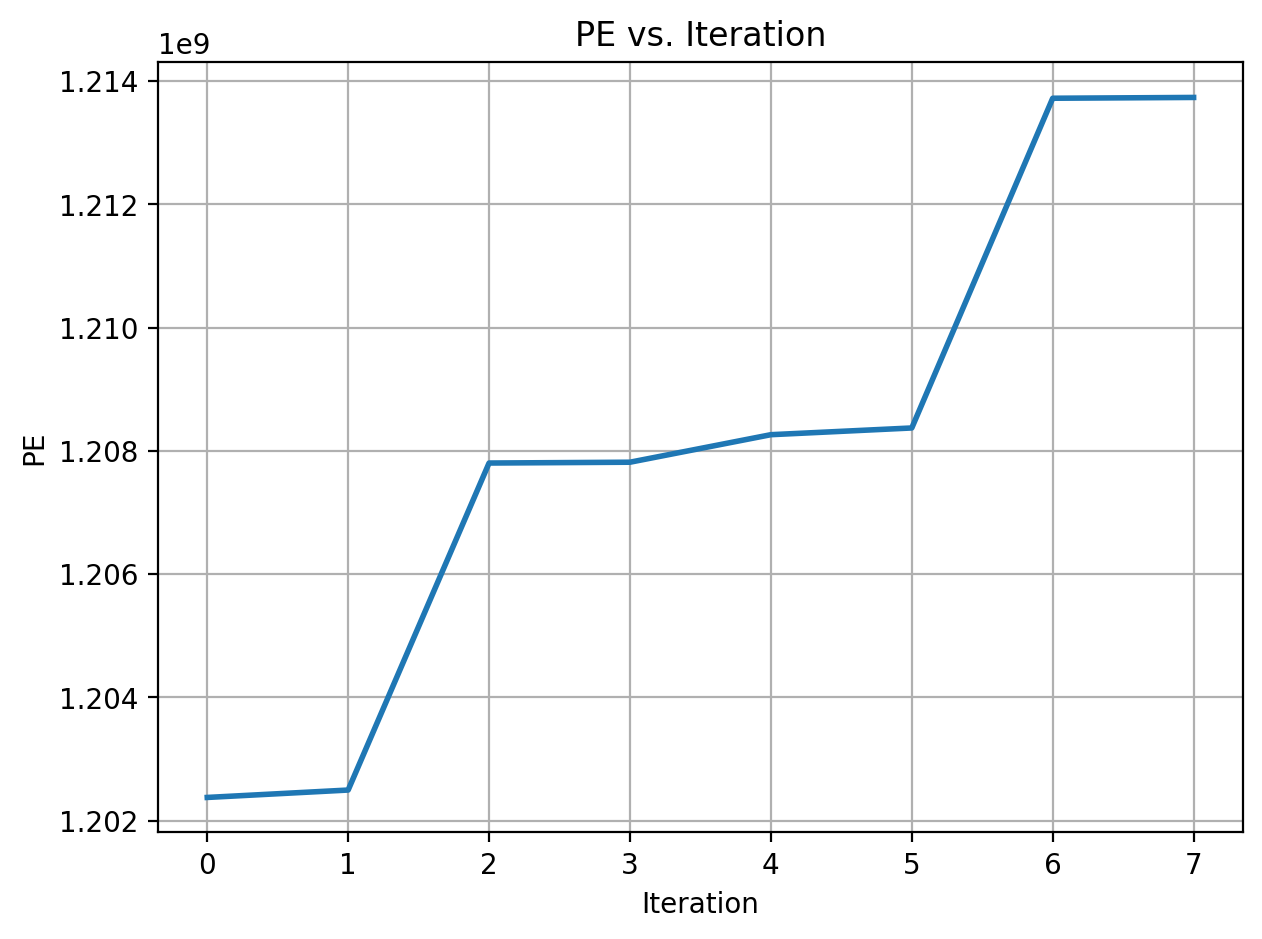

In [33]:
# plot pe vs. iteration
plt.figure(figsize=(7,5), dpi=100)
plt.plot(model.pe_each_iter, linewidth=2)
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('PE')
plt.title('PE vs. Iteration')
plt.show()


### Exercise 9

### Exercise 10

In [39]:
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True, early_stop_iterations=1)
model.fit(
    cps_2,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(cps_2)

Completed iteration 0 of matching
	Number of matched groups formed in total:  377
	Unmatched treated units:  635 out of a total of  1150 treated units
	Unmatched control units:  3221 out of a total of  4365 control units
	Number of matches made this iteration:  1659
	Number of matches made so far:  1659
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1202376350.38702
Completed iteration 1 of matching
	Number of matched groups formed in total:  503
	Unmatched treated units:  21 out of a total of  1150 treated units
	Unmatched control units:  353 out of a total of  4365 control units
	Number of matches made this iteration:  3482
	Number of matches made so far:  5141
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1202496430.8826103
5141 units matched. We stopped after iteration 1


In [37]:
result

,female,simplified_race,county,class94,age_group
0,1.0,0.0,10.0,3.0,4.0
1,0.0,2.0,*,3.0,2.0
2,0.0,0.0,8.0,3.0,5.0
3,0.0,0.0,*,1.0,3.0
4,0.0,0.0,24.0,3.0,2.0
...,...,...,...,...,...
5509,0.0,0.0,*,3.0,5.0
5510,1.0,3.0,247.0,3.0,2.0
5511,0.0,3.0,*,3.0,4.0
5512,0.0,2.0,246.0,3.0,1.0


Getting Back a Dataset:

In [36]:
def get_dataframe(model, result_of_fit):
    
    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [40]:
get_dataframe(model, result)

AssertionError: 